# Imports

In [31]:
import pandas as pd
import numpy as np
from datetime import date, timedelta
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from livelossplot import PlotLossesKeras
from scipy.signal import savgol_filter
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import *
from keras.models import Sequential, Model
from keras.layers import LSTM, Dense, Dropout, Input, Merge, Average, Maximum, Concatenate
from keras.layers.advanced_activations import LeakyReLU, PReLU, ELU, ThresholdedReLU
from sklearn.linear_model import LinearRegression
from sklearn.metrics import *

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pyflux as pf
np.random.seed(101)
%matplotlib inline

In [32]:
df = pd.read_csv("Data.csv")
trunc_df = df[df.columns[list(range(0,7))+list(range(80,94))]]
trunc_df['tot_occ'] = trunc_df['language1']+trunc_df['language2']+trunc_df['language3']+trunc_df['others']
trunc_df = pd.concat([trunc_df[trunc_df.columns[:5]],trunc_df['tot_occ'],trunc_df[trunc_df.columns[5:-1]]], axis=1)
trunc_df = trunc_df.reset_index()

# Model

In [33]:
def test_stationarity(timeseries):
    
    plt.figure(figsize=fig_size)
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=10).mean()
    rolstd = timeseries.rolling(window=10).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

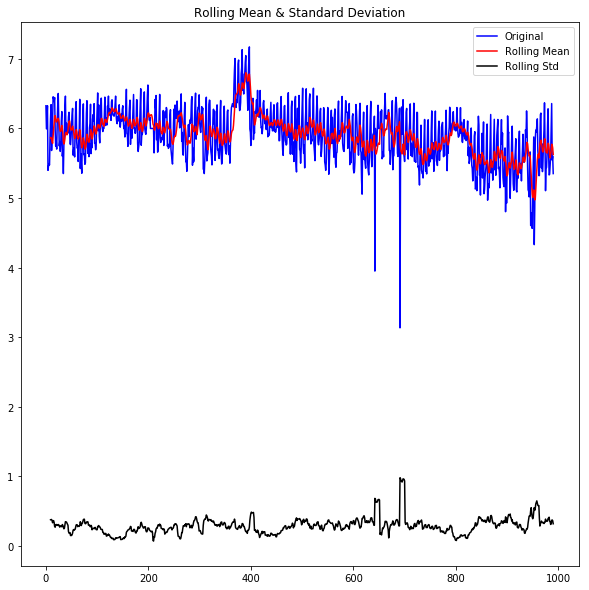

Results of Dickey-Fuller Test:
Test Statistic                  -2.742966
p-value                          0.066894
#Lags Used                      22.000000
Number of Observations Used    968.000000
Critical Value (1%)             -3.437123
Critical Value (5%)             -2.864530
Critical Value (10%)            -2.568362
dtype: float64


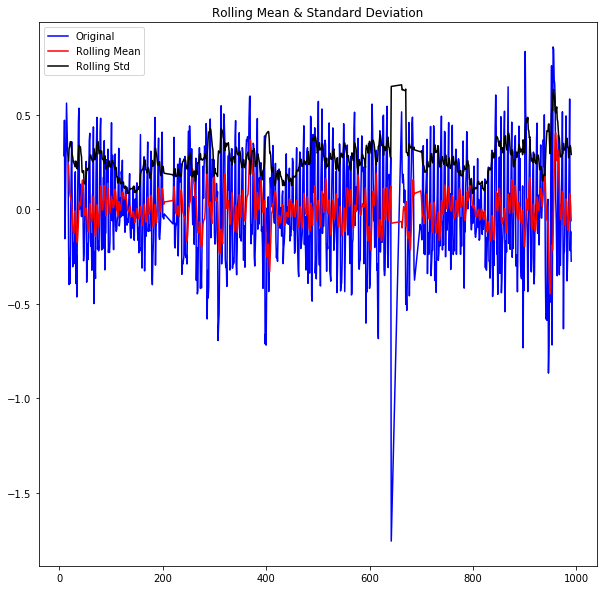

Results of Dickey-Fuller Test:
Test Statistic                -7.484265e+00
p-value                        4.683957e-11
#Lags Used                     2.100000e+01
Number of Observations Used    9.150000e+02
Critical Value (1%)           -3.437517e+00
Critical Value (5%)           -2.864704e+00
Critical Value (10%)          -2.568455e+00
dtype: float64


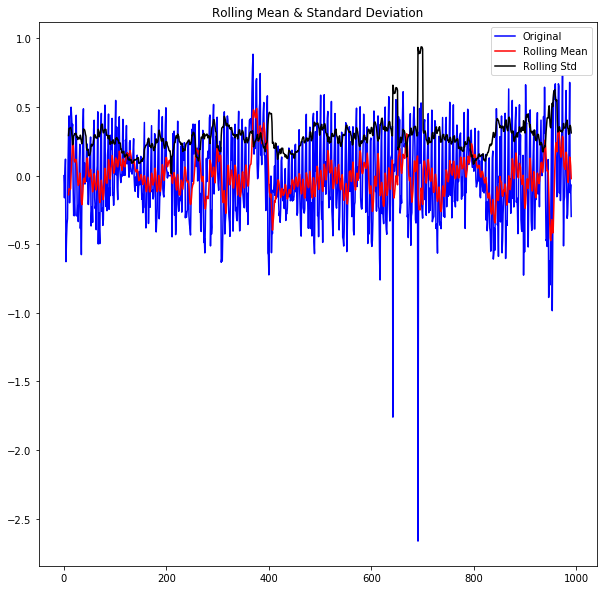

Results of Dickey-Fuller Test:
Test Statistic                -5.743685e+00
p-value                        6.191546e-07
#Lags Used                     2.200000e+01
Number of Observations Used    9.680000e+02
Critical Value (1%)           -3.437123e+00
Critical Value (5%)           -2.864530e+00
Critical Value (10%)          -2.568362e+00
dtype: float64


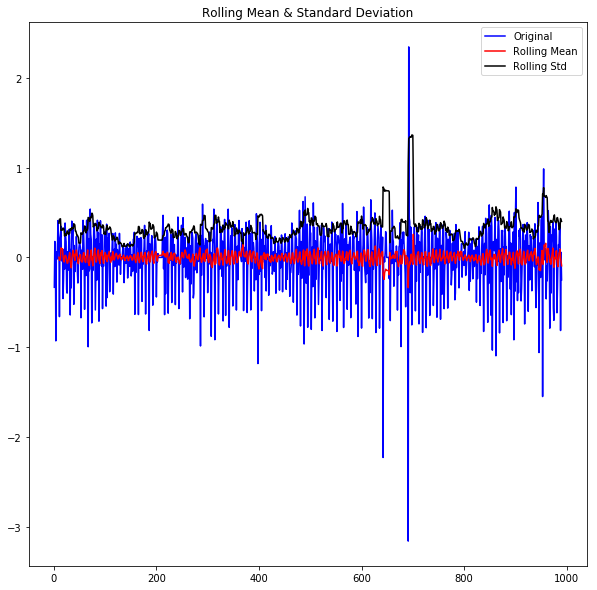

Results of Dickey-Fuller Test:
Test Statistic                -8.459781e+00
p-value                        1.578744e-13
#Lags Used                     2.200000e+01
Number of Observations Used    9.580000e+02
Critical Value (1%)           -3.437194e+00
Critical Value (5%)           -2.864562e+00
Critical Value (10%)          -2.568379e+00
dtype: float64


In [35]:
ts_log = np.log(ts)
ts_log.dropna(inplace=True)

moving_avg = ts_log.rolling(10).mean()
ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.dropna(inplace=True)

expwighted_avg = ts_log.ewm(halflife=12).mean()
ts_log_ewma_diff = ts_log - expwighted_avg

ts_log_diff = ts_log - ts_log.shift(1)
ts_log_diff.dropna(inplace=True)

ts_log = ts_log.replace([np.inf, -np.inf, np.nan],6)
ts_log_moving_avg_diff = ts_log_moving_avg_diff.replace([np.inf, -np.inf, np.nan],ts_log_moving_avg_diff.mean())
ts_log_ewma_diff = ts_log_ewma_diff.replace([np.inf, -np.inf, np.nan],0)
ts_log_diff = ts_log_diff.replace([np.inf, -np.inf, np.nan],0)

test_stationarity(ts_log)
test_stationarity(ts_log_moving_avg_diff)
test_stationarity(ts_log_ewma_diff)
test_stationarity(ts_log_diff)

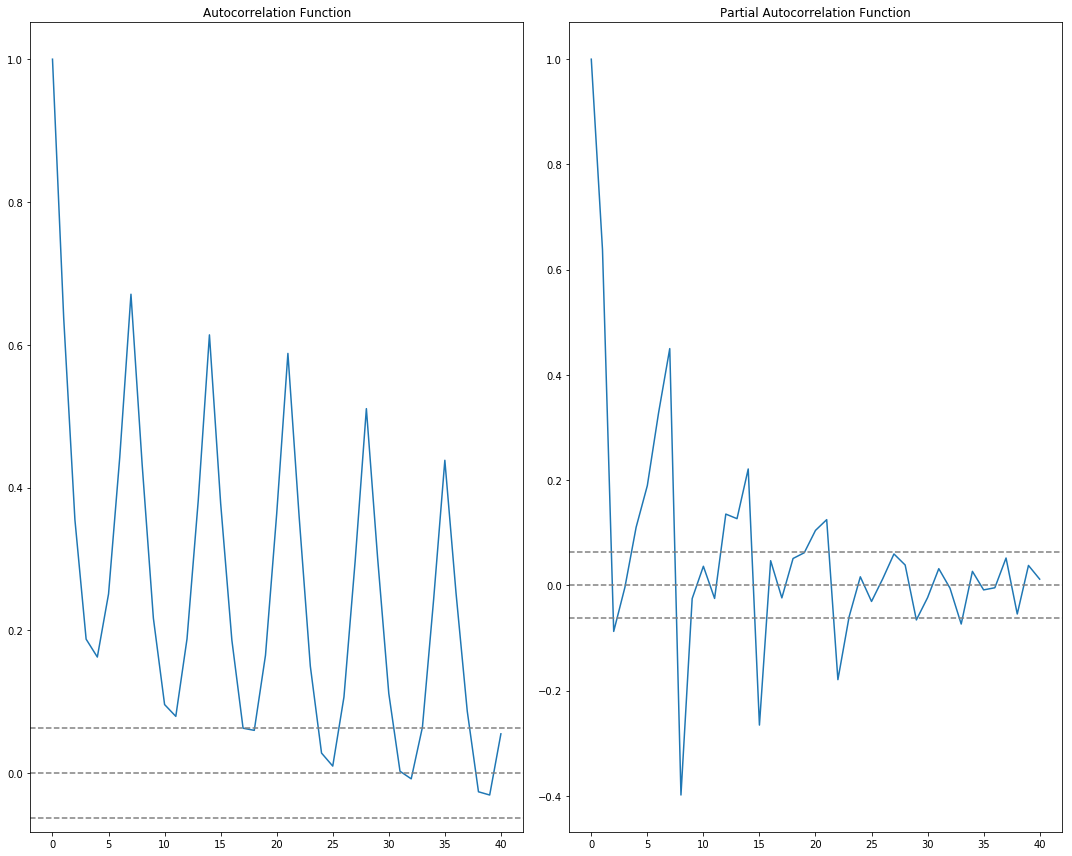

In [36]:


lag_acf = acf(ts, nlags=40)
lag_pacf = pacf(ts, nlags=40, method='ols')

plt.figure(figsize=(15,12))
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

# Regular ARIMA

In [37]:
from statsmodels.tsa.arima_model import ARIMA
 
ts_log = ts_log.replace([np.inf, -np.inf],0)

testSplit = int(0.8*ts.shape[0])
model1 = ARIMA(ts[:testSplit], order=(7,1 , 7))
results_ARIMA = model1.fit() 
pred = results_ARIMA.predict(exog=ts[testSplit:])
test = ts[testSplit:]

In [38]:
testSplit = int(0.8*ts.shape[0])

In [41]:
ts.shape[0]-testSplit


199

In [55]:
train, test = ts.values[:testSplit], ts.values[testSplit:]
history = [x for x in train]
predictions = []
train = []
trainPred = []
trainInp = history[:100]


In [ ]:
print('Printing Predicted vs Expected Values...')
print('\n')
lrPred = []
for t in range(len(test)):
    model = ARIMA(history, order=(6,1,2))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(float(yhat))
    obs = ts.values[testSplit:][t]
    history.append(obs)
    yhat = np.array(yhat).reshape(-1,1)
    print('predicted=%.3f, expected=%.3f, predictedERR=%.3f' % (yhat, obs, abs(yhat-obs)))



In [50]:
len (predictions)

199

In [ ]:
yTrue = np.array(history[-len (predictions):])
yPred = np.array(predictions)
yTrue.shape,yPred.shape

In [ ]:
np.mean(np.abs(yTrue-yPred)*100./yTrue)

In [61]:
predTable = np.hstack((np.array(yPred).reshape(-1,1),np.array(yTrue).reshape(-1,1)))
predTable = pd.DataFrame(predTable,columns=['ARIMA','yTest'])
predTable.to_csv('ARIMA-food1.csv',index=False)

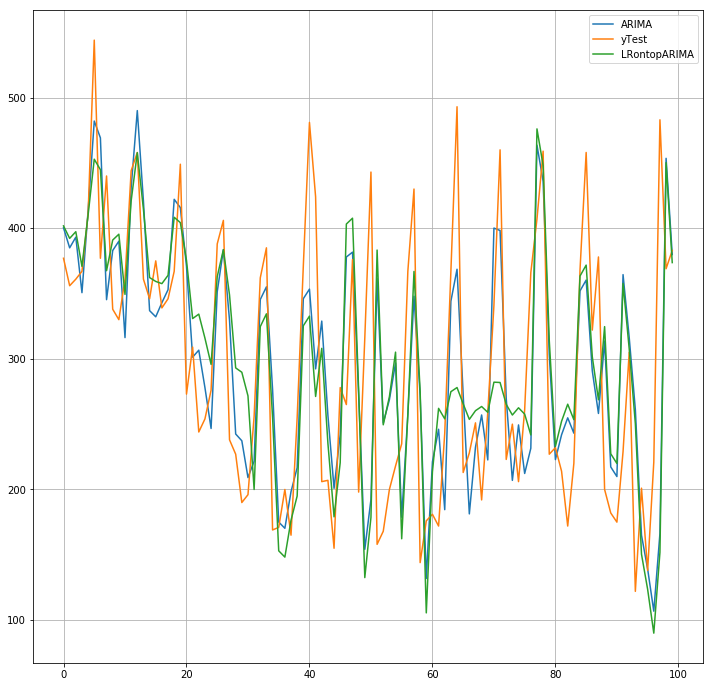

In [95]:
predTable.iloc[:100,:].plot(figsize=(12,12),grid=True)

In [ ]:
output = model_fit.forecast(steps=4)
output, test[-5:]

In [ ]:
testSplit,(test).shape,np.array(predictions).shape

In [ ]:
pred = np.array(predictions)

In [ ]:
plt.figure(figsize=fig_size)
plt.plot(test)
plt.plot(pred, color='red')
plt.show()

In [ ]:
test.shape,pred.shape

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
print(mean_absolute_error(test,pred),np.sqrt(mean_squared_error(test,pred)),r2_score(test,pred))

In [ ]:
np.mean(np.abs(pred-test)/test)

# SARIMA

In [ ]:
trunc_df.index = pd.DatetimeIndex(trunc_df.Date)
trunc_df.drop(['index','Date'],axis=1,inplace=True)

In [ ]:
ts = trunc_df['food1']

In [ ]:
testSplit = round(len(ts)*0.8)

In [ ]:
model = SARIMAX(ts[:testSplit],order=(5,1,6),seasonal_order=(1,0,0,7),enforce_stationarity=False,enforce_invertibility=False,time_varying_regression=False,mle_regression=True)
model_fit = model.fit(display=True)

In [ ]:
pred = model_fit.forecast(len(ts[testSplit:]))
test = ts[testSplit:].values
pred.shape,test.shape

In [ ]:
plt.figure(figsize=(12,12))
plt.plot(test)
plt.plot(np.array(predictions), color='red')
plt.show()
print(mean_absolute_error(test,predictions))
print(mean_squared_error(test,predictions))
print(np.mean(np.abs(test-predictions)/test))

In [ ]:
size = int(len(ts) - 15)
train, test = ts.values[:testSplit], ts.values[testSplit:]
history = [x for x in train]
predictions = list()

print('Printing Predicted vs Expected Values...')
print('\n')
for t in range(len(test)):
    model = SARIMAX(history, order=(5,1,6),seasonal_order=(1,0,0,7),enforce_stationarity=False,enforce_invertibility=False,time_varying_regression=False,mle_regression=True)
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(float(yhat))
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))

error = mean_squared_error(test, predictions)

print('\n')
print('Printing Mean Squared Error of Predictions...')
print('Test MSE: %.6f' % error)



In [ ]:
size = int(len(ts) - 15)
train, test = ts.values[:testSplit], ts.values[testSplit:]
history = [x for x in train]
predictions = list()

print('Printing Predicted vs Expected Values...')
print('\n')
for t in range(len(test)):
    model = SARIMAX(history, order=(2,1,2),seasonal_order=(1,0,0,7),enforce_stationarity=False,enforce_invertibility=False,time_varying_regression=False,mle_regression=True)
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(float(yhat))
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))

error = mean_squared_error(test, predictions)

print('\n')
print('Printing Mean Squared Error of Predictions...')
print('Test MSE: %.6f' % error)



In [ ]:
test.shape,np.array(predictions).shape

In [ ]:
model_fit.arparams